In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/AML Final Project

/content/drive/MyDrive/Colab Notebooks/AML Final Project


In [ ]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import math
import torch.nn.functional as F

import torch
from torch import nn
from torch import optim

from undersampling import *
from dataset import *
from nets import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load Image

In [ ]:
# dataset = TrainDataset('h5_train')
# # save the dataset
# torch.save(dataset, 'dataset.pth')

In [ ]:
# load the dataset
dataset1 = torch.load('dataset.pth')

train_samples = int(len(dataset1)*0.75)
print(len(dataset1))
test_samples = len(dataset1)-train_samples
train_set, test_set = torch.utils.data.random_split(dataset1, [train_samples, test_samples])
trainloader = DataLoader(train_set,shuffle=True)
testloader = DataLoader(test_set,shuffle=True)

160


In [ ]:
# # make a 10 image grid
# for i in range(10):
#     image = dataset1[i]
#     plt.figure(figsize=(10,5))
#     plt.subplot(1,2,1)
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')

#     k_space = np.fft.fft2(image)
#     k_space = np.fft.fftshift(k_space)
#     k_space = np.abs(k_space)
#     k_space = np.log(k_space)
#     plt.subplot(1,2,2)
#     plt.imshow(k_space, cmap='gray')
#     plt.axis('off')

# plt.show()


#Apply undersampling

In [ ]:
# construct undersampling mask
my_undersampling_factor = 10**2
my_lambda_poisson = 1
# undersampling_mask = create_mask(k_space.shape, my_undersampling_factor, my_lambda_poisson)
# # convert to tensor
# undersampling_mask = torch.cuda.FloatTensor(undersampling_mask)

# undersample simpulation
hr_image = next(iter(trainloader))
# convert to 3 channel
hr_image_3 = hr_image.repeat(3, 1, 1)
hr_image_3 = hr_image_3.unsqueeze(0)
print(hr_image_3.shape)

torch.Size([1, 3, 512, 214])


/content/drive/MyDrive/Colab Notebooks/AML Final Project/undersampling.py:60: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  mask = torch.cuda.FloatTensor(mask)


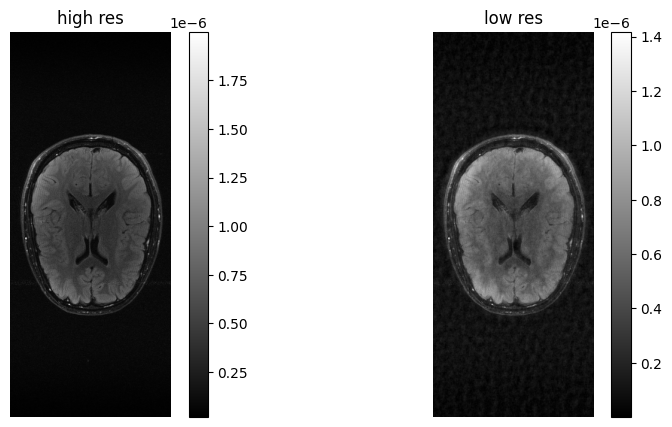

In [ ]:
A = underSamplingOperator(my_undersampling_factor, my_lambda_poisson)
testLR_3 = A.AHA(hr_image_3.cuda())
# testLR_3 = testLR_3+0.01*torch.randn(testLR_3.shape).cuda()

# print(testLR_3)
# print(hr_image_3.max())

# # convert testLR to k-space
# testLR_k = torch.fft.fft2(testLR)
# testLR_k = torch.fft.fftshift(testLR)

# print(hr_image_3.shape)
# print(hr_image_3.squeeze(0).permute(1, 2, 0).numpy().shape)

grayscale_transform  = T.Grayscale(num_output_channels=1)
hr_image_1 = grayscale_transform(hr_image_3)
hr_image_1 = hr_image_1.squeeze(1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(hr_image_1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('high res')

testLR_1 = grayscale_transform(testLR_3)
testLR_1 = testLR_1.squeeze(1)

# print(testLR_1)

plt.subplot(1,2,2)
plt.imshow(testLR_1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('low res')

plt.show()



In [ ]:
# # calculate the acceleration factor
# total_pixels = testLR_k.shape[2]*testLR_k.shape[1]
# mask_pixels = torch.sum(undersampling_mask)
# acceleration_factor = total_pixels/mask_pixels
# print(acceleration_factor)

#CG Block

$$\mathbf x_{\rm LS} =  \arg \min_{\mathbf x} \|\mathbf A\mathbf x-\mathbf y\|^2 ---(2)$$

This problem is solved using conjugate gradient optimization, which gives $\mathbf x_{\rm LS} =  \left(\mathbf A^T \mathbf A + \lambda~ \mathbf I\right)^{-1}\left(\mathbf A^T\mathbf b\right)$, where $\lambda=0.01$.

In [ ]:
cg = cg_block(100,1e-2)
lhs = lambda x:A.AHA(x)+0.01*x # spatial
rhs = testLR_3
sigma = 0.05 * testLR_3.max()
noise = torch.randn(testLR_3.shape).cuda() * sigma.cuda()
x0 = testLR_3 + noise

print(rhs.shape)

out = cg(lhs,rhs,x0).detach().cpu()

print(out)
print(testLR_3)


torch.Size([1, 3, 512, 214])
tensor([[[[-1.9114e-08, -9.8123e-08,  7.1301e-09,  ...,  1.0300e-07,
            2.4755e-07, -6.0372e-08],
          [-6.4044e-08, -3.9897e-08, -7.8481e-08,  ...,  1.4482e-07,
            1.3000e-07, -6.0102e-08],
          [ 8.7594e-08,  3.5389e-08,  2.3990e-07,  ..., -8.7824e-08,
           -2.6844e-08, -6.5792e-08],
          ...,
          [ 6.8149e-08,  1.8142e-07,  1.2126e-07,  ..., -5.4001e-10,
           -2.6496e-08,  2.1206e-08],
          [ 1.7202e-08, -3.2734e-08,  9.3315e-08,  ...,  8.1546e-08,
            1.2479e-07, -3.0995e-08],
          [ 1.1230e-07,  1.2093e-07,  1.2218e-07,  ...,  2.7483e-07,
            3.2170e-08,  3.2225e-08]],

         [[-1.0492e-07,  8.7369e-08, -4.3417e-08,  ...,  5.8463e-08,
            2.3666e-07,  2.5567e-08],
          [ 5.3497e-08, -4.2930e-08, -7.2539e-08,  ...,  1.6292e-07,
            2.2707e-08, -1.0500e-08],
          [-3.4071e-08, -6.1774e-09,  5.3880e-08,  ...,  6.3338e-11,
            1.8995e-08, -5.47

torch.Size([1, 3, 512, 214])
torch.Size([1, 3, 512, 214])


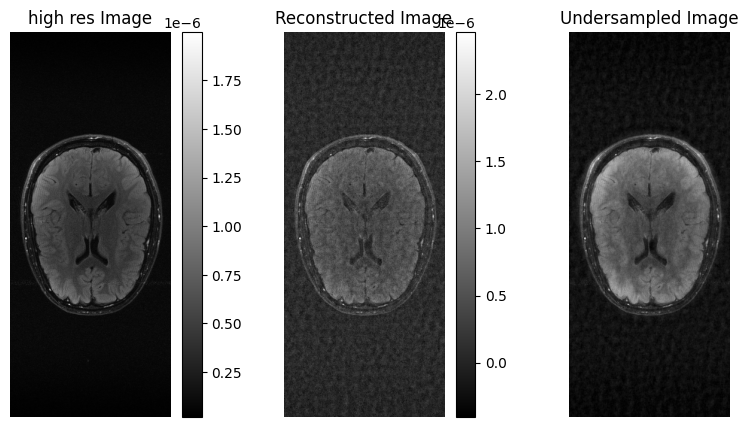

In [ ]:
print(out.shape)
print(testLR_3.shape)

out_1 = grayscale_transform(out)
out_1 = out_1.squeeze(1)

# plot the images
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.imshow(hr_image.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('high res Image')

plt.subplot(1,3,2)
plt.imshow(out_1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Reconstructed Image')

plt.subplot(1,3,3)
plt.imshow(testLR_1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Undersampled Image')

plt.show()

# # now plot the images
# fig, ax = plt.subplots(1,3,figsize=(15,5))
# im = ax[0].imshow(hr_image.cpu().detach().numpy().squeeze())
# ax[0].set_title('Original Image')


# testLR_3_show = testLR_3.squeeze(0).permute(1, 2, 0)
# testLR_3_show = testLR_3_show.clamp(0, 1)


# ax[1].imshow(testLR_3_show)
# ax[1].set_title('Undersampled Image')

# out_show = out.squeeze(0).permute(1, 2, 0)
# out_show = out_show.clamp(0, 1)

# im2 = ax[2].imshow(out_show)
# ax[2].set_title('Reconstructed Image')

# plt.colorbar(im, ax = ax[0])
# plt.colorbar(im2, ax = ax[2])


# plt.show()


In [ ]:
class modl(nn.Module):

    def __init__(self, A,net,lam,nCGiter=5,tol=1e-4,nUnrolls=1)-> None:
        super(modl, self).__init__();

        # Feature extraction layer.
        self.A = A
        self.net = net
        self.lam = torch.tensor(lam,dtype=torch.float64).requires_grad_(True)
        self.cg = cg = cg_block(nCGiter,tol)
        self.nUnrolls = nUnrolls

    def forward(self, Atb:torch.Tensor,x0:torch.Tensor ) -> torch.Tensor:

        x = x0.clone()

        # YOUR CODE BELOW
        lhs = lambda x: A.AHA(x)+self.lam*x

        for i in range(self.nUnrolls):
            z = Atb + self.lam*self.net(x)
            x = self.cg(lhs,z,x0=x)

        return x


0.00021116781846662 lam= 0.10000084802065183


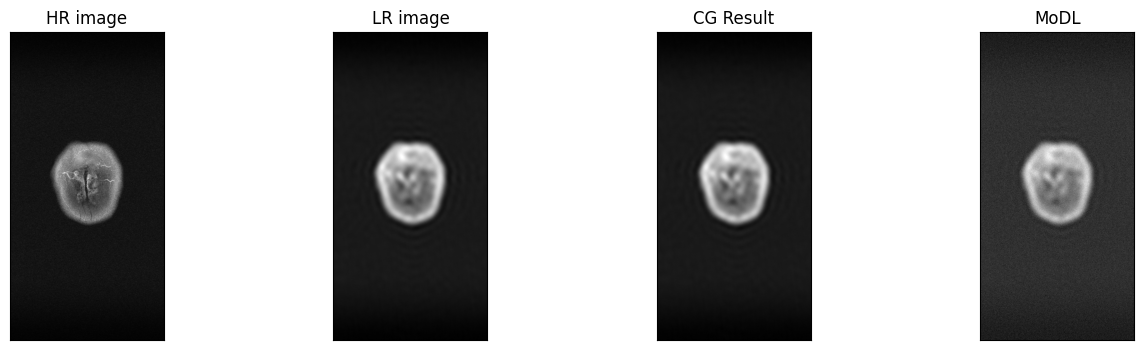

1.894334914010851e-08 lam= 0.1000008480240976


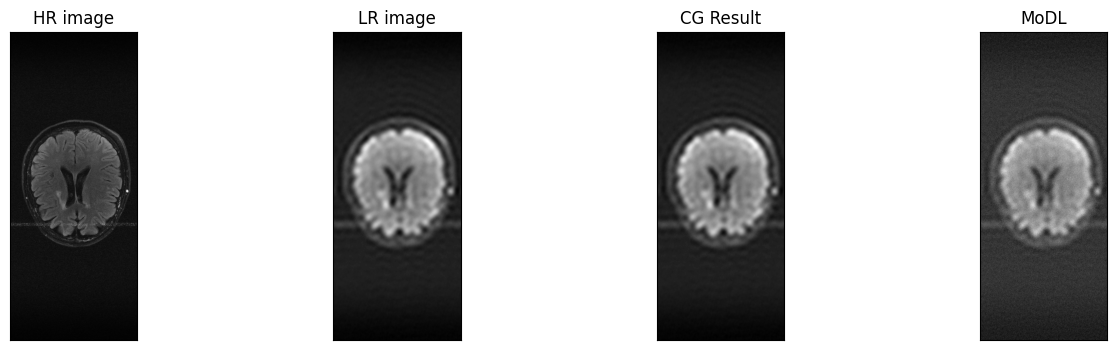

1.895262274154225e-08 lam= 0.10000084802415908


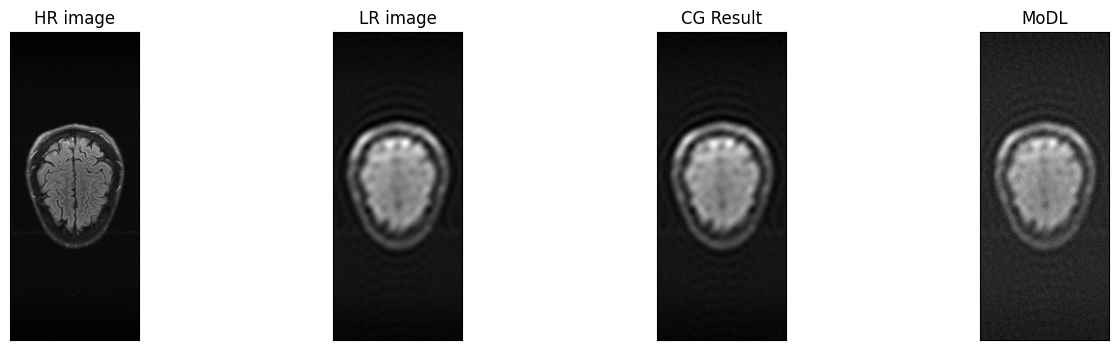

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_undersampling_factor = 10**2
my_lambda_poisson = 0.01
A = underSamplingOperator(my_undersampling_factor, my_lambda_poisson)
net = SRCNN(32,upSamplingFactor=1).to(device)
maxUnrolls = 4
model = modl(A,net,0.1,nUnrolls=maxUnrolls)

lossfn = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD([
                {'params': model.net.parameters(),'lr': 1e-3},
                {'params':model.lam,'lr': 1e-7}
            ], lr=1e-2, momentum=0.9)


for epoch in range(30):
    epochloss = 0

    for hr_image in trainloader:
        # x = int(hr_image.shape[2]/A.factor)*A.factor
        # y = int(hr_image.shape[3]/A.factor)*A.factor
        # hr_image = hr_image[:,:,:x,:y]

        # 1-3 channel
        hr_image_3 = hr_image.repeat(3, 1, 1)
        hr_image_3 = hr_image_3.unsqueeze(0)
        # print(hr_image_3.shape)

        testHR = A.AHA(hr_image_3.cuda())
        sigma = 0.05 * testHR.max()
        noise = torch.randn(testHR.shape).cuda() * sigma.cuda()
        cg_start = testHR + noise
        x0 = cg(lhs,testHR.cuda(),cg_start.cuda()).detach().cpu()


        testHR = testHR.to(torch.float32)
        x0 = x0.to(torch.float32)
        out = model(testHR.to(device),x0.to(device))

        cost =lossfn(out,hr_image_3.to(device))
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        epochloss += cost
    if np.mod(epoch,10)==0:
        print(epochloss.item()/dataset1.__len__(),'lam=',model.lam.item())

        fig, ax = plt.subplots(1,4,figsize=(16,4))
        # gray scale
        hr_image_1 = grayscale_transform(hr_image_3)
        hr_image_1 = hr_image_1.squeeze(1)
        s=ax[0].imshow(hr_image_1.cpu().detach().numpy().squeeze(), cmap='gray')
        s=ax[0].set_title('HR image')
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)

        # img = np.transpose(np.asarray(testLR[0].cpu()),(1,2,0))
        # s=ax[1].imshow(np.uint8(255*img))
        # s=ax[1].set_title('LR image')
        # ax[1].get_xaxis().set_visible(False)
        # ax[1].get_yaxis().set_visible(False)

        testHR_1 = grayscale_transform(testHR)
        testHR_1 = testHR_1.squeeze(1)
        s=ax[1].imshow(testHR_1.cpu().detach().numpy().squeeze(), cmap='gray')
        s=ax[1].set_title('LR image')
        ax[1].get_xaxis().set_visible(False)
        ax[1].get_yaxis().set_visible(False)


        cgresult = cg(lhs,testHR,testHR).detach().cpu()
        # gray scale
        cgresult_1 = grayscale_transform(cgresult)
        cgresult_1 = cgresult_1.squeeze(1)
        s=ax[2].imshow(cgresult_1.cpu().detach().numpy().squeeze(), cmap='gray')
        s=ax[2].set_title('CG Result')
        s=ax[2].get_xaxis().set_visible(False)
        s=ax[2].get_yaxis().set_visible(False)

        out_1 = grayscale_transform(out)
        out_1 = out_1.squeeze(1)
        s=ax[3].imshow(out_1.cpu().detach().numpy().squeeze(), cmap='gray')
        s=ax[3].set_title('MoDL')
        ax[3].get_xaxis().set_visible(False)
        ax[3].get_yaxis().set_visible(False)
        #if(nUnrolls<maxUnrolls):
        #    nUnrolls = nUnrolls+1

        plt.show()



In [36]:
# save the model
# torch.save(model.state_dict(), '04_08_300_mask_10_05.pth')
torch.save(model.state_dict(), '04_08_30_mask_10_001_noise_005.pth')


#Testing

##Show results from noisy

Results from noisy image


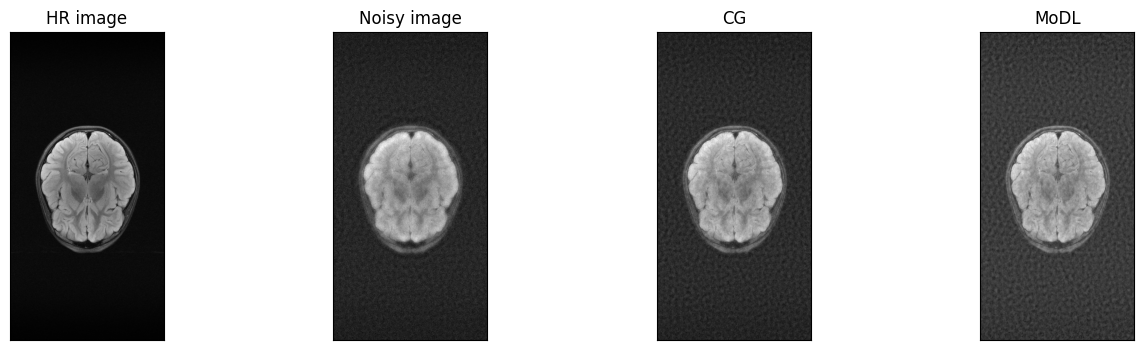

Results from undersampling image


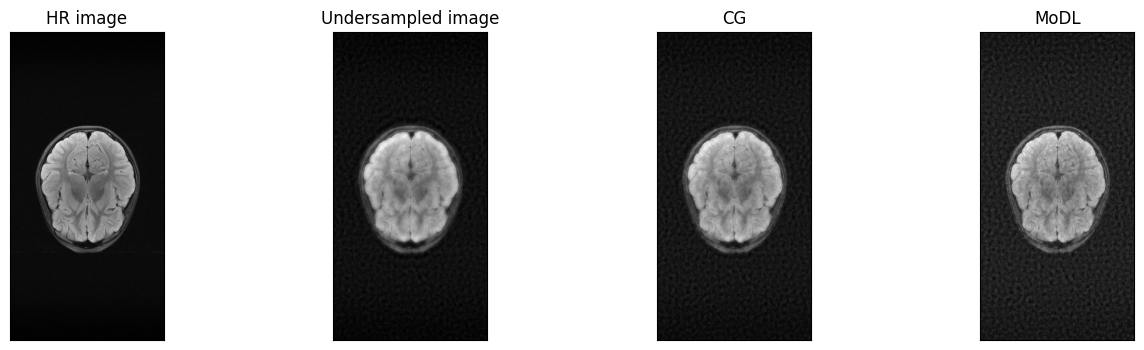

In [34]:
hr_image = next(iter(testloader))

my_undersampling_factor = 10**2
my_lambda_poisson = 0.5
A = underSamplingOperator(my_undersampling_factor, my_lambda_poisson)

# 1-3 channel
hr_image_3 = hr_image.repeat(3, 1, 1)
hr_image_3 = hr_image_3.unsqueeze(0)

testHR = A.AHA(hr_image_3.cuda())
sigma = 0.05 * testHR.max()
noise = torch.randn(testHR.shape).cuda() * sigma.cuda()
cg_start = testHR + noise
x0 = cg(lhs,testHR.cuda(),cg_start.cuda()).detach().cpu()

testHR = testHR.to(torch.float32)
x0 = x0.to(torch.float32)
out = model(testHR.to(device),x0.to(device))


# plots from noisy
print('Results from noisy image')
fig, ax = plt.subplots(1,4,figsize=(16,4))

# display original
hr_image_1 = grayscale_transform(hr_image_3)
hr_image_1 = hr_image_1.squeeze(1)
s=ax[0].imshow(hr_image_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[0].set_title('HR image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

# display noisy
cgresult_1 = grayscale_transform(cg_start)
cg_start_1 = cgresult_1.squeeze(1)
s=ax[1].imshow(cg_start_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[1].set_title('Noisy image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

# cg from noise
cgresult_1 = grayscale_transform(x0)
cgresult_1 = cgresult_1.squeeze(1)
s=ax[2].imshow(cgresult_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[2].set_title('CG')
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

# modl output
out_1 = grayscale_transform(out)
out_1 = out_1.squeeze(1)
s=ax[3].imshow(out_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[3].set_title('MoDL')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

plt.show()

# calculate the psnr
psnr = 10*torch.log10(1/torch.mean((out-hr_image_3)**2))
print('PSNR with noisy image:',psnr)


#--------------------------------------------------------------------------

cg_start = testHR
x0 = cg(lhs,testHR.cuda(),cg_start.cuda()).detach().cpu()

testHR = testHR.to(torch.float32)
x0 = x0.to(torch.float32)
out = model(testHR.to(device),x0.to(device))


# plots from undersampling
print('Results from undersampling image')
fig, ax = plt.subplots(1,4,figsize=(16,4))

# display original
hr_image_1 = grayscale_transform(hr_image_3)
hr_image_1 = hr_image_1.squeeze(1)
s=ax[0].imshow(hr_image_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[0].set_title('HR image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

# display undersampling
cgresult_1 = grayscale_transform(cg_start)
cg_start_1 = cgresult_1.squeeze(1)
s=ax[1].imshow(cg_start_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[1].set_title('Undersampled image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

# cg from undersampling
cgresult_1 = grayscale_transform(x0)
cgresult_1 = cgresult_1.squeeze(1)
s=ax[2].imshow(cgresult_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[2].set_title('CG')
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

# modl output
out_1 = grayscale_transform(out)
out_1 = out_1.squeeze(1)
s=ax[3].imshow(out_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[3].set_title('MoDL')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

plt.show()

# calculate the psnr
psnr = 10*torch.log10(1/torch.mean((out-hr_image_3)**2))
print('PSNR with undersampled image:',psnr)